# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

Данные находятся в файле: __/datasets/autos.csv__.

__Признаки__
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

__Целевой признак__
* Price — цена (евро)

## Подготовка данных

### Подключим необходимые библиотеки.

In [ ]:
pip install --upgrade category_encoders

In [91]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import warnings

import category_encoders as ce

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

### Откроем таблицу, посмотрим внешний вид и изучим общую информацию о данных.

In [92]:
df = pd.read_csv('/datasets/autos.csv')
display(df.head())
df.info()
print()
number_of_lines = df.shape[0]
print('Количество строк:', number_of_lines)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### **Вывод:**
* Загрузили и посмотрели внешний вид и изучили общую информацию о данных
* Необходима подготовка данных.

### Приведем в порядок названия столбцов

In [93]:
print(df.columns)

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')


In [94]:
df.columns = df.columns.str.lower()
print(df.columns)

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')


In [95]:
df.rename(columns = {'datecrawled':'date_crawled', 
                     'vehicletype':'vehicle_type', 
                     'registrationyear':'registration_year',
                     'registrationmonth':'registration_month', 
                     'fueltype':'fuel_type', 
                     'notrepaired':'not_repaired', 
                     'datecreated':'date_created', 
                     'numberofpictures':'number_of_pictures', 
                     'postalcode':'postal_code',
                     'lastseen':'last_seen'}, inplace=True)
display(df.columns)

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### **Вывод:**
Названия столбцов переписали в «змеином регистре» убрали заглавные буквы, но это было не принципиально.

### Приведем столбцы date_crawled, date_created и  last_seen к типу datetime

In [96]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format = '%Y-%m-%dT%H:%M:%S')
df['date_created'] = pd.to_datetime(df['date_created'], format = '%Y-%m-%dT%H:%M:%S')
df['last_seen'] = pd.to_datetime(df['last_seen'], format = '%Y-%m-%dT%H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  not_repaired        283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

### Посмотрим общее состояние по пропускам

In [97]:
print('Общее количество ячеек с пропусками в df:', df.isna().sum().sum())

Общее количество ячеек с пропусками в df: 181077


#### Посмотрим TOP столбцов по пропускам

In [98]:
df.isna().sum().sort_values(ascending=False)

not_repaired          71154
vehicle_type          37490
fuel_type             32895
gearbox               19833
model                 19705
date_crawled              0
price                     0
registration_year         0
power                     0
kilometer                 0
registration_month        0
brand                     0
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

#### Посмотрим, как пересекаются пропуски. Для этого напишем функцию, которая выводит на экран в виде таблицы количество строк с количеством пропусков в строке и функцию удаления строк с количеством пропусков более 'n'

In [99]:
def out_report(data):
    stat_out = data.isna().astype('int')
    stat_out['number_of_cross'] = stat_out.sum(axis=1)
    stat_out_result = pd.DataFrame(stat_out['number_of_cross'].value_counts().reset_index())
    data['number_of_cross'] = stat_out['number_of_cross']
    stat_out_result.rename(columns = {'index':'Количество пропусков в строке', 
                         'number_of_cross':'Число строк'}, inplace=True)
    stat_out_result['Процент отсутствующих данных в строке'] = round(stat_out_result['Количество пропусков в строке']
                                                                      * 100 / data.shape[1], 0)
    stat_out_result['Процент строк от общего датафрейма'] = round(stat_out_result['Число строк']
                                                                      * 100 / data.shape[0], 1)
    display(stat_out_result)
    
    
def delete_cross(data, n=None):
    out_report(data)
    if n != None:
        k = data.shape[0]
        print()
        print()
        print('Количество строк до удаления:', k)
        print('Удаляем строки с количеством пропусков более:', n)
        data = data.drop(data[data['number_of_cross'] > n].index)
        k1 = data.shape[0]
        print('Количество строк после удаления:', k1, ', удалено', k - k1, 'строк')
        print()
        print('Общая информация по пропускам после удаления строк, содержащих', n + 1, 'и более пропусков' )
        
        out_report(data)
    else:
        print('Нет параметров для удаления')
    data = data.drop(columns = ['number_of_cross'],axis = 1)    
    return data    


#### Узнаем сколько строк имеют сколько пропусков

In [100]:
out_report(df)

,Количество пропусков в строке,Число строк,Процент отсутствующих данных в строке,Процент строк от общего датафрейма
0,0,245814,0.0,69.4
1,1,64318,6.0,18.2
2,2,26209,12.0,7.4
3,3,10008,18.0,2.8
4,4,5783,24.0,1.6
5,5,2237,29.0,0.6


Некоторые строки содержат до пяти пропусков и замена пропусков в них на что-либо будет снижать качество модели обучения. Поэтому удалим строки, содержащие три и более пропуска.

In [101]:
df = delete_cross(df, 2)

display(df)

,Количество пропусков в строке,Число строк,Процент отсутствующих данных в строке,Процент строк от общего датафрейма
0,0,245814,0.0,69.4
1,1,64318,6.0,18.2
2,2,26209,12.0,7.4
3,3,10008,18.0,2.8
4,4,5783,24.0,1.6
5,5,2237,29.0,0.6




Количество строк до удаления: 354369
Удаляем строки с количеством пропусков более: 2
Количество строк после удаления: 336341 , удалено 18028 строк

Общая информация по пропускам после удаления строк, содержащих 3 и более пропусков


,Количество пропусков в строке,Число строк,Процент отсутствующих данных в строке,Процент строк от общего датафрейма
0,0,245814,0.0,73.1
1,1,64318,6.0,19.1
2,2,26209,12.0,7.8


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354363,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27,0,26624,2016-03-29 10:17:23
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,0,2694,2016-03-21 10:42:49
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19,0,87439,2016-04-07 07:15:26


Гляним теперь на пропуски.

In [102]:
df.isna().sum().sort_values(ascending=False)

not_repaired          55104
vehicle_type          22122
fuel_type             18540
model                 12016
gearbox                8954
date_crawled              0
price                     0
registration_year         0
power                     0
kilometer                 0
registration_month        0
brand                     0
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

### **Вывод:**
Удалили из датафрейма строки содержащие 3 и более пропусков, по причине того, что замена пропусков в них на что-либо будет снижать качество модели обучения.

### Посмотрим на состав значений столбцов

#### Столбец model — модель автомобиля

In [103]:
print(df['model'].unique())
print()
print()
print('Количество строк с пропусками  в model:', df['model'].isna().sum(), ', это:'
      , round(df['model'].isna().sum() * 100 / df.shape[0], 1), '% от всего датафрейма')

['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'twingo' 'a_klasse' 'scirocco' '5er' 'meriva'
 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio' 'kadett'
 'kangoo' 'one' 'fortwo' '1er' 'b_klasse' 'signum' 'astra' 'a8' 'jetta'
 'polo' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156' 'escort'
 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'combo' 'focus' 'tt' 'corsa'
 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' 'z_reihe' 'sportage' 'sorento'
 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'insignia' 'a3' 'almera'
 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'sharan' '6_reihe'
 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'rio' 'touareg' 'logan'
 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3' 'viano' 's_klasse' '1_reihe'
 'avensis' 'roomster' 'sl' 'kaefer' 'santa' 'cooper' 'leon' '4_reihe' 'a5'
 '500' '

Модель автомобиля является важнейшим признаком при обучении и при замене пропусков каким-либо методом незначительное количество "неправильных" значений в этом столбце может значительно повлиять на дальнейшее обучение, поэтому ничем заменять пропуски в этом столбце не будем и просто удалим строки содержащие пропуски в столбце model, тем более, что мы потеряем всего 3.6 % от всего датафрейма.

In [104]:
df = df.dropna(subset=['model'])
df.isna().sum().sort_values(ascending=False)

not_repaired          52166
vehicle_type          21172
fuel_type             17131
gearbox                8736
date_crawled              0
price                     0
registration_year         0
power                     0
model                     0
kilometer                 0
registration_month        0
brand                     0
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

#### Столбец gearbox — тип коробки передач

In [105]:
print(df['gearbox'].value_counts())

manual    253085
auto       62504
Name: gearbox, dtype: int64


В столбце gearbox возможны еще два вида коробок это вариатор и робот, поэтому будет разумно заменить пропуски на other, т. к. мы не знаем причину появления пропусков. Возможно сервис «Не бит, не крашен» имеет ограниченный функционал при размещении объявления и таких вариантов, как вариатор или робот там выбрать нельзя, и пользователи либо пропускают, либо выбирают автомат или на крайний случай ручную.

In [106]:
print(df.shape)
df['gearbox'] = df['gearbox'].fillna('other')
print(df.shape)

(324325, 16)
(324325, 16)


#### Столбец not_repaired — была машина в ремонте или нет

In [107]:
print(df['not_repaired'].value_counts())
print('Количество строк с пропусками  в not_repaired:', df['not_repaired'].isna().sum(), ', это:'
      , round(df['not_repaired'].isna().sum() * 100 / df.shape[0], 1), '% от всего датафрейма')

no     238634
yes     33525
Name: not_repaired, dtype: int64
Количество строк с пропусками  в not_repaired: 52166 , это: 16.1 % от всего датафрейма


Достаточно много пропусков (16%) в столбце not_repaired. Удалять не будем. Заменим на "неопределенно".

In [108]:
print(df.shape)
df['not_repaired'] = df['not_repaired'].fillna('unknown')
print(df.shape)

(324325, 16)
(324325, 16)


#### Столбец vehicle_type — тип автомобильного кузова

In [109]:
print(df['vehicle_type'].value_counts())
print('Количество строк с пропусками  в vehicle_type:', df['vehicle_type'].isna().sum(), ', это:'
      , round(df['vehicle_type'].isna().sum() * 100 / df.shape[0], 1), '% от всего датафрейма')

sedan          87954
small          76226
wagon          62841
bus            27726
convertible    19244
coupe          15182
suv            11211
other           2769
Name: vehicle_type, dtype: int64
Количество строк с пропусками  в vehicle_type: 21172 , это: 6.5 % от всего датафрейма


Не так много пропусков (7%) в столбце not_repaired. Удалять не будем. Заменим на "неопределенно".

In [110]:
print(df.shape)
df['vehicle_type'] = df['vehicle_type'].fillna('unknown')
print(df.shape)

(324325, 16)
(324325, 16)


#### Столбец fuel_type — тип топлива

In [111]:
print(df['fuel_type'].value_counts())
print('Количество строк с пропусками  в fuel_type:', df['fuel_type'].isna().sum(), ', это:'
      , round(df['fuel_type'].isna().sum() * 100 / df.shape[0], 1), '% от всего датафрейма')

petrol      205869
gasoline     95444
lpg           4942
cng            541
hybrid         206
other          126
electric        66
Name: fuel_type, dtype: int64
Количество строк с пропусками  в fuel_type: 17131 , это: 5.3 % от всего датафрейма


Так же "гадать" не будем, пропусков (5%) в столбце not_repaired. Удалять не будем. Заменим на "неопределенно".

In [112]:
print(df.shape)
df['fuel_type'] = df['fuel_type'].fillna('unknown')
print(df.shape)

(324325, 16)
(324325, 16)


#### **Вывод:**
Детально прошлись по всем столбцам, содержащим пропуски:
* Столбец model — модель автомобиля —  3.6 % пропусков. Пропуски удалены.
* Столбец gearbox — тип коробки передач —  3.6 % пропусков. Пропуски удалены.
* Столбец not_repaired — была машина в ремонте или нет. Пропусков (16%). Удалять не будем. Заменим на " неопределенно "
* Столбец vehicle_type — тип автомобильного кузова. Пропусков (7%). Удалять не будем. Заменим на "неопределенно"
* Столбец fuel_type — тип топлива. Пропусков (5%). Удалять не будем. Заменим на "неопределенно"

### Теперь посмотрим на возможные аномалии в данных

In [113]:
display(df.head())
df.info()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-04-07 03:16:57
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-04-06 19:17:07


<class 'pandas.core.frame.DataFrame'>
Int64Index: 324325 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        324325 non-null  datetime64[ns]
 1   price               324325 non-null  int64         
 2   vehicle_type        324325 non-null  object        
 3   registration_year   324325 non-null  int64         
 4   gearbox             324325 non-null  object        
 5   power               324325 non-null  int64         
 6   model               324325 non-null  object        
 7   kilometer           324325 non-null  int64         
 8   registration_month  324325 non-null  int64         
 9   fuel_type           324325 non-null  object        
 10  brand               324325 non-null  object        
 11  not_repaired        324325 non-null  object        
 12  date_created        324325 non-null  datetime64[ns]
 13  number_of_pictures  324325 no

#### Напишем функцию построения гистограммы и график «ящик с усами» + describe

In [114]:
def form_fun(col, bins, rang=None):
    t = 'Гистограмма столбца ' + col
    b = 'boxplot столбца ' + col
    fig, axes = plt.subplots(1,2,figsize=(17,5))

    df[col].hist(bins=bins, ax=axes[0], range=rang)
    sns.boxplot(x=df[col], ax=axes[1])  

    axes[0].set_title(t)
    axes[1].set_title(b)
    
    print(df[col].describe())

    plt.show()

#### Столбец 'price'

count    324325.000000
mean       4591.281724
std        4549.742828
min           0.000000
25%        1200.000000
50%        2900.000000
75%        6600.000000
max       20000.000000
Name: price, dtype: float64


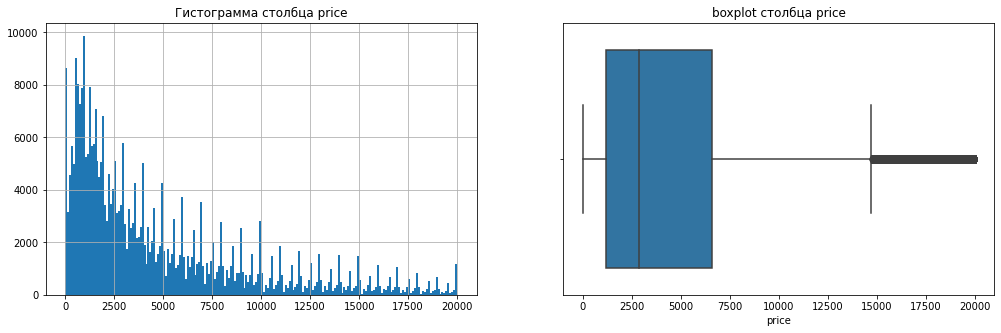

In [115]:
form_fun('price', 200)

Посмотрим на несколько строк с нулевой ценой

In [116]:
display(df[df['price'] == 0].head(6))

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58
111,2016-03-19 18:40:12,0,unknown,2017,manual,0,golf,5000,12,petrol,volkswagen,unknown,2016-03-19,0,21698,2016-04-01 08:47:05
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11,0,27432,2016-03-12 23:47:10
231,2016-03-16 22:06:24,0,wagon,2001,manual,115,mondeo,150000,0,unknown,ford,unknown,2016-03-16,0,57627,2016-03-26 11:17:50
466,2016-03-24 10:58:40,0,unknown,2016,auto,197,3er,150000,12,gasoline,bmw,no,2016-03-24,0,99867,2016-03-25 19:46:09
579,2016-03-27 11:37:43,0,sedan,1996,manual,170,5er,150000,0,petrol,bmw,no,2016-03-27,0,48529,2016-03-27 11:37:43


Видно что значения разные, бросается в глаза только нулевые значения количества фотографий. Сравним с остальным датафреймом.

In [117]:
print(df[df['price'] == 0]['number_of_pictures'].value_counts())
print(df[df['price'] != 0]['number_of_pictures'].value_counts())

0    7235
Name: number_of_pictures, dtype: int64
0    317090
Name: number_of_pictures, dtype: int64


Оказалось, что во всём датафрейме значения количества фотографий только ноль. Ну тогда удалим строки с нулевыми значениями цены и весь столбец 'number_of_pictures', т. к. это нули будут только мешать качеству обучения модели.

In [118]:
print(df.shape)
df = df.drop(df[df['price'] == 0].index)
print(df.shape)

(324325, 16)
(317090, 16)


#### Столбец 'number_of_pictures' удалим

In [119]:
print(df.shape)
df = df.drop(columns = ['number_of_pictures'],axis = 1)
print(df.shape)

(317090, 16)
(317090, 15)


#### Столбец 'registration_year'

count    317090.000000
mean       2003.253064
std          18.233512
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        6500.000000
Name: registration_year, dtype: float64


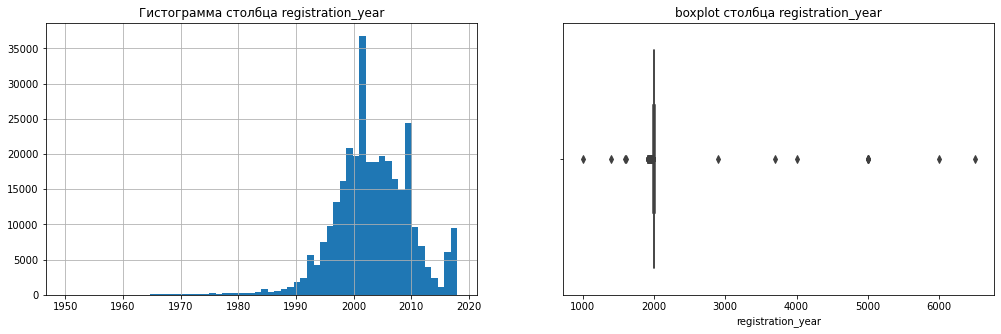

In [120]:
form_fun('registration_year', 60, (1950,2018))

Есть выбросы как в меньшую, так и большую сторону. Есть раритетные автомобили до 1960г, но их участие усложнит и исказит обучение модели. Также если обращать внимание на время выгрузки датафрейма, можно сказать, что строки старше этого времени являются выбросами или аномалиями. Поэтому оставим для рассмотрения период от 1960г до 2016г

In [121]:
print(df.shape)
df = df.drop(df[df['registration_year'] < 1960].index)
df = df.drop(df[df['registration_year'] > 2016].index)
print(df.shape)

(317090, 15)
(307348, 15)


count    307348.000000
mean       2002.761166
std           6.367174
min        1960.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64


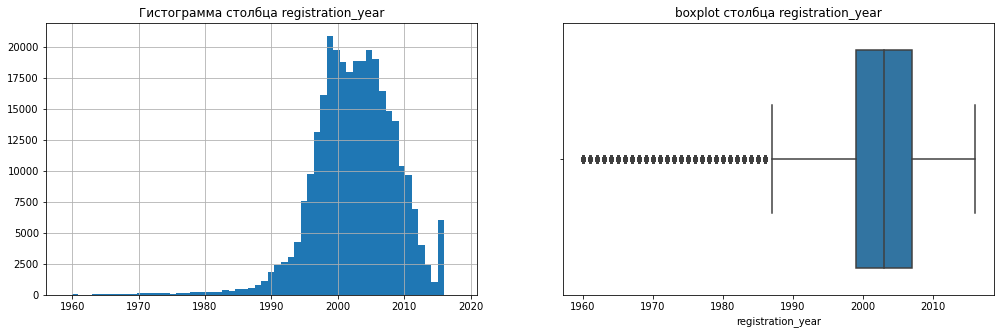

In [122]:
form_fun('registration_year', 60, (1959,2018))

#### Столбец 'power'

count    307348.000000
mean        114.405257
std         179.002289
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64


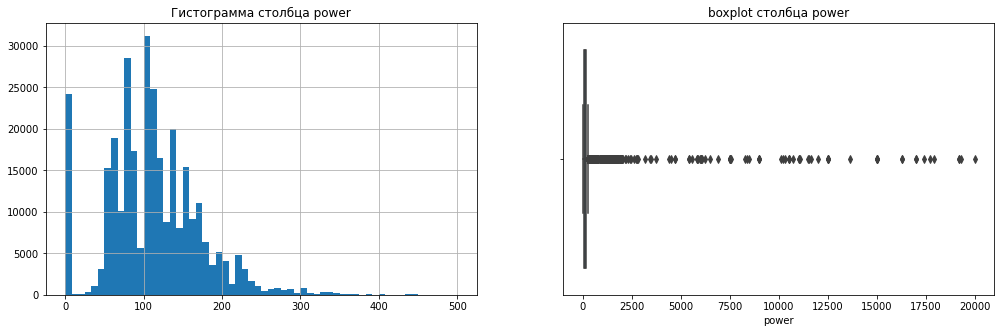

In [123]:
form_fun('power', 60, (0,500))

Посмотрим на количество нулевых значений мощьности.

In [124]:
print(df[df['power'] == 0]['power'].count())

24204


В связи с тем, что одни и те же автомобили изготавливаются с двигателями разной мощности (разной комплектации) заменить нулевые значения мощности каким-либо методом будет не корректно, поэтому удалим их. А также возьмём нижний порог мощности 30 л. с. т. к. ниже значения встречаются крайне редко и относятся либо к раритетным авто, либо к электромобилям. Электромобили оставим.

In [125]:
print(df.shape)
df = df.drop(df[(df['fuel_type'] != 'electric') & (df['power'] < 30)].index)
print(df.shape)

(307348, 15)
(282639, 15)


Что касается выбросов в большую сторону, то необходимо удалить все значения больше 500 л. с. и более 400 относящиеся ко всем типам кузова, кроме suv, wagon и bus.

In [126]:
print(df.shape)
df = df.drop(df[df['power'] > 500].index)
print(df.shape)

(282639, 15)
(282304, 15)


In [127]:
print(df.shape)
df = df.drop(df[(df['vehicle_type'] != 'suv') 
                & (df['vehicle_type'] != 'wagon') 
                & (df['vehicle_type'] != 'bus') 
                & (df['power'] > 400)].index)
print(df.shape)

(282304, 15)
(282163, 15)


#### Столбец 'kilometer'

count    282163.000000
mean     128354.054217
std       36504.698355
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64


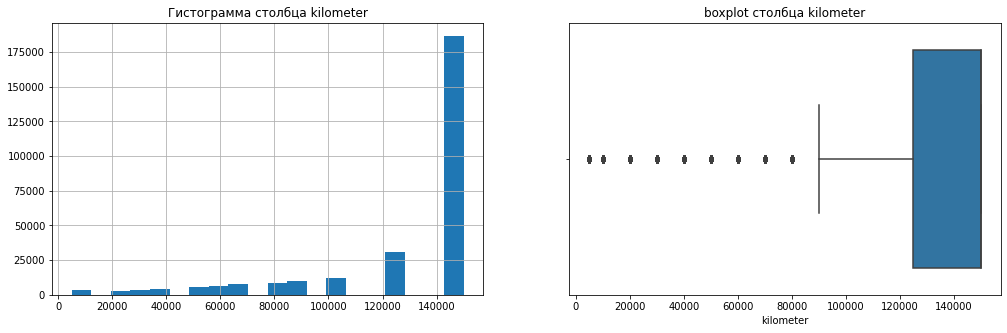

In [128]:
form_fun('kilometer', 20)

Здесь все нормально.

#### Столбец 'registration_month'

count    282163.000000
mean          6.052140
std           3.555648
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: registration_month, dtype: float64


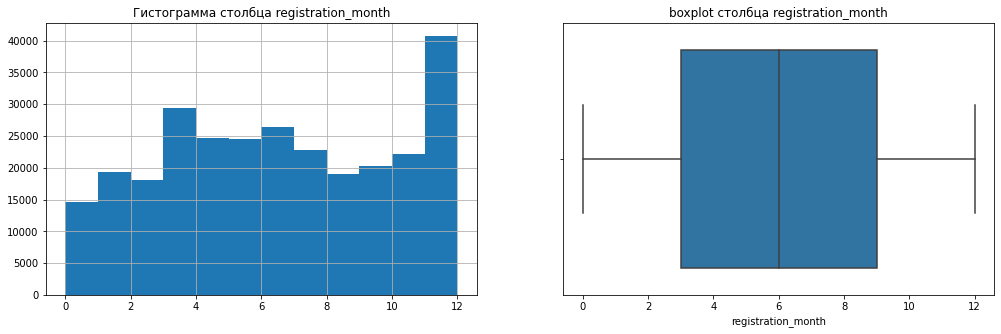

In [129]:
form_fun('registration_month', 12)

Здесь все нормально.

#### Столбец 'postal_code'

In [130]:
print(df['postal_code'].value_counts())

10115    794
65428    485
60311    259
66333    256
52525    242
        ... 
31088      1
82444      1
79685      1
67680      1
29587      1
Name: postal_code, Length: 8104, dtype: int64


Это пятизначный Zip Code относящийся к европейским странам. Видно, что некоторые индексы повторяются по несколько сот раз. Можно предположить, что они относятся к разным городам и странам в Европе. Скорее всего и цены по странам и городам различаются хоть и "единая Европа". Поэтому этот столбец оставим.

#### Столбец 'date_crawled'

In [131]:
print(df['date_crawled'].sort_values(ascending=False))

90713    2016-04-07 14:36:58
339649   2016-04-07 14:36:56
301030   2016-04-07 14:36:55
53739    2016-04-07 14:36:54
204218   2016-04-07 14:36:53
                 ...        
220604   2016-03-05 14:06:25
324763   2016-03-05 14:06:24
176823   2016-03-05 14:06:24
220583   2016-03-05 14:06:23
329497   2016-03-05 14:06:22
Name: date_crawled, Length: 282163, dtype: datetime64[ns]


Последнее время скачивания анкеты из базы это 2016-04-07 14:36:58, а значит дата создания анкеты позже быть не может.

In [132]:
print(df['date_created'].sort_values(ascending=False))

115159   2016-04-07
46194    2016-04-07
108787   2016-04-07
64751    2016-04-07
227832   2016-04-07
            ...    
75598    2015-09-04
221002   2015-09-04
175103   2015-08-10
86601    2015-08-07
4001     2015-03-20
Name: date_created, Length: 282163, dtype: datetime64[ns]


Здесь все нормально.

In [133]:
df.info()
print()
print('Осталось после всей обработки', df.shape[0], 'строк', 'это', round(df.shape[0] * 100 / number_of_lines, 1), '% строк от начальных данных')
number_of_lines

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282163 entries, 2 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        282163 non-null  datetime64[ns]
 1   price               282163 non-null  int64         
 2   vehicle_type        282163 non-null  object        
 3   registration_year   282163 non-null  int64         
 4   gearbox             282163 non-null  object        
 5   power               282163 non-null  int64         
 6   model               282163 non-null  object        
 7   kilometer           282163 non-null  int64         
 8   registration_month  282163 non-null  int64         
 9   fuel_type           282163 non-null  object        
 10  brand               282163 non-null  object        
 11  not_repaired        282163 non-null  object        
 12  date_created        282163 non-null  datetime64[ns]
 13  postal_code         282163 no

354369

#### **Вывод:**
Детально прошлись по аномалиям в данных:
* Столбец 'price'. Удалены строки с нулевыми значениями цены.
* Удален весь столбец 'number_of_pictures', т. к. в нем только нулевые значения и будут мешать качеству обучения модели.
* Столбец 'registration_year'. Оставлен для рассмотрения период от 1960г до 2016г
* Столбец 'power'. Удалены нулевые значения.  Взят нижний порог мощности 30 л. но электромобили оставим. Что касается выбросов в большую сторону, то удалены все значения больше 500 л. с. и более 400 относящиеся ко всем типам кузова, кроме suv, wagon и bus.
* Столбцы 'kilometer', 'registration_month', 'date_crawled и 'postal_code' в порядке.
* В результате всей обработки данных было оставлено 80% строк от начальных данных.

### Проверим датафрейм на наличие дубликатов

In [134]:
print('Количество дубликатов строк в df:', df.duplicated().sum(), ', это:'
      , df.duplicated().sum() * 100 / df.shape[0], '% от всего датафрейма')

Количество дубликатов строк в df: 4 , это: 0.0014176203116638255 % от всего датафрейма


Всего 4 явных дубликата. Удалим их.

In [135]:
print(df.shape)
df = df.drop_duplicates().reset_index(drop=True)
print(df.shape)

(282163, 15)
(282159, 15)


In [136]:
display(df.head())

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,postal_code,last_seen
0,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,90480,2016-04-05 12:47:46
1,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17
2,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:21
3,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,33775,2016-04-06 19:17:07
4,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,67112,2016-04-05 18:18:39


### **Вывод:**

Дубликатов 4 строки. Удалены.

## Обучение моделей

### Напишем функцию разделения данных на обучающую и тестовую выборки в отношении 3:1 c  преобразованием категориальных признаков и масштабированием данных

Из обучающей выборке удалим временные столбцы: 
* date_crawled — дата скачивания анкеты из базы
* date_created — дата создания анкеты
* last_seen — дата последней активности пользователя

и целевой признак:
* price — цена (евро)

Преобразуем категориальные признаки в численные техникой порядкового кодирования (Ordinal Encoding), для того чтоб не возникало ошибок при работе методов обучения, связанных с попытками преобразовать все элементы string в вещественное число.

А также выполним масштабирование данных

In [139]:
def splitting(data):
    print('Размер поступивщих данных:', data.shape)
    
    data = data.drop(columns = ['date_crawled', 'date_created', 'last_seen'],axis = 1)
    print('Размер данных после удаления временных столбцов:', data.shape)
    
    col = df.select_dtypes(include='object').columns.tolist()
    print('Столбцы с категориальными признаками :', col)
    
    oe = ce.OrdinalEncoder(cols = col)
    data_ordinal = oe.fit_transform(data)
    print('Размер данных после кодирования столбцов с категориальными признаками:', data_ordinal.shape)
    
    features = data_ordinal.drop(['price'], axis=1)
    target = data_ordinal['price']
    print('Размер features:', features.shape)
    print('Размер target:', target.shape[0])

    features_train, features_test, target_train, target_test = train_test_split(
                            features, target, test_size=0.25, random_state=12345) # 25% данных для тестовой выборки
    print('Размер обучающей features выборки:', features_train.shape)
    print('Размер тестовой features выборки:', features_test.shape)
    print('Размер обучающей target выборки:', target_train.shape[0])
    print('Размер тестовой target выборки:', target_test.shape[0])
    
    col_rest = []
    for i in features_train.columns:
        if not (i in col):
            col_rest.append(i)
    print('Столбцы подлежащие масштабированию:', col_rest)
    
    numeric = col_rest 
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_test[numeric] = scaler.transform(features_test[numeric])
    print()
    print('--------------------------------Результат масштабирования features_train-------------------------------')
    display(features_train.agg(['min','max']))
    print()
    print('--------------------------------Результат масштабирования features_test---------------------------------')
    display(features_test.agg(['min','max']))

      
    return (features_train, features_test, target_train, target_test)

### Разделим данные на обучающую и тестовую выборки.

In [140]:
features_train, features_test, target_train, target_test = splitting(df)

Размер поступивщих данных: (282159, 15)
Размер данных после удаления временных столбцов: (282159, 12)
Столбцы с категориальными признаками : ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']
Размер данных после кодирования столбцов с категориальными признаками: (282159, 12)
Размер features: (282159, 11)
Размер target: 282159
Размер обучающей features выборки: (211619, 11)
Размер тестовой features выборки: (70540, 11)
Размер обучающей target выборки: 211619
Размер тестовой target выборки: 70540
Столбцы подлежащие масштабированию: ['registration_year', 'power', 'kilometer', 'registration_month', 'postal_code']

--------------------------------Результат масштабирования features_train-------------------------------


,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,postal_code
min,1,-6.927264,1,-2.304552,1,-3.383083,-1.701963,1,1,1,-1.950897
max,9,2.107356,3,7.241783,249,0.592418,1.672840,8,39,3,1.888792



--------------------------------Результат масштабирования features_test---------------------------------


,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,postal_code
min,1,-6.927264,1,-2.304552,1,-3.383083,-1.701963,1,1,1,-1.950897
max,9,2.107356,3,7.241783,249,0.592418,1.672840,8,39,3,1.888792


### Напишем функцию расчета RMSE.


In [141]:
def RMSE_fun(target, predictions):
    result = mean_squared_error(target, predictions) ** 0.5
    return result

### Напишем функцию подбора гиперпераметров для модели методом GridSearch с кросс-валидацией (cv=5) по обучающей выборке и фиксацией времени обучения и предсказания.

In [142]:
def search_best_parameters(model, param):
    start_time = timeit.default_timer()
    search = GridSearchCV(model
                            , param_grid = param
                            , cv=5
                            , scoring = make_scorer(RMSE_fun, greater_is_better=False)
                            , n_jobs=-1)
    
    warnings.filterwarnings("ignore", category=FutureWarning)
    search.fit(features_train,target_train)
    
    elapsed_first = round(timeit.default_timer() - start_time, 3)
    start_time = timeit.default_timer()
    predict = search.predict(features_test)
    elapsed_second = round(timeit.default_timer() - start_time, 3)
    result = round(RMSE_fun(target_test, predict), 0)
    print('Время обучения:', elapsed_first)
    print('Время предсказания:', elapsed_second)
    print('RMSE:', result)
    print('Лучшие гиперпараметры:', search.best_params_)
    return result, elapsed_first, elapsed_second
    


### Создадим модели DecisionTreeRegressor,  RandomForestRegressor, CatBoostRegressor, LighGBMRegressor и константную модель со средним предсказанием, подберем лучшие параметры, обучим и получим предсказания с расчетом RMSE и временем этих операций.

Далее, для более быстрого обучения моделей, всего по одному или двух гиперпараметров подбираются лучшие. Добиться чуть лучших результатов по RMSE можно, если выбрать большой перечень гиперпараметров для GridSearch, но время поиска лучшей комбинации этих гиперпараметров и обучения модели окажется значительно долгим. В данном проекте основной целью является не поиск оптимальных гиперпараметров, а исследование скорости работы моделей обучения и качество моделей.

#### Модель DecisionTreeRegressor 

In [143]:
decision_tree = DecisionTreeRegressor(random_state=2)
param = {'max_depth':range (3,10)}
best_decision_tree = search_best_parameters(decision_tree, param)

Время обучения: 14.246
Время предсказания: 0.011
RMSE: 2030.0
Лучшие гиперпараметры: {'max_depth': 9}


#### Модель RandomForestRegressor 

In [144]:
random_forest = RandomForestRegressor(random_state=2)
param = {'n_estimators':range(45, 65, 5), 'max_depth':range (10,16)}
best_random_forest = search_best_parameters(random_forest, param)
print(best_random_forest)

Время обучения: 3151.547
Время предсказания: 0.856
RMSE: 1605.0
Лучшие гиперпараметры: {'max_depth': 15, 'n_estimators': 60}
(1605.0, 3151.547, 0.856)


#### Модель CatBoostRegressor

In [145]:
catboost = CatBoostRegressor(random_state=2, silent=True)
param = {'n_estimators': [80,90,100], 'max_depth': [8,10], 'learning_rate': [0.1]}
best_catboost = search_best_parameters(catboost, param)
print(best_catboost)

Время обучения: 159.518
Время предсказания: 0.033
RMSE: 1645.0
Лучшие гиперпараметры: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
(1645.0, 159.518, 0.033)


#### Модель LightGBMRegressor

In [146]:
light_gbm = LGBMRegressor(random_state=2)
param = {'n_estimators': [80,90], 'max_depth': [10,12], 'learning_rate': [0.1]}
best_light_gbm = search_best_parameters(light_gbm, param)
print(best_light_gbm)

Время обучения: 111.489
Время предсказания: 0.602
RMSE: 1660.0
Лучшие гиперпараметры: {'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 90}
(1660.0, 111.489, 0.602)


#### Константная модель (проверка на адекватность)

In [147]:
start_time = timeit.default_timer()
predictions_mean = pd.Series([target_train.mean() for i in range(len(target_test))])
elapsed_first = round(timeit.default_timer() - start_time, 3)
start_time = timeit.default_timer()
result = round(RMSE_fun(target_test, predictions_mean), 0)
elapsed_second = round(timeit.default_timer() - start_time, 3)
const_model = result, elapsed_first, elapsed_second
print('Время обучения:', elapsed_first)
print('Время предсказания:', elapsed_second)
print('RMSE:', result)

Время обучения: 18.668
Время предсказания: 0.001
RMSE: 4635.0


Большое значение RMSE = 4635 (даже в 2,5 больше чем для линейной регрессии) для константной модели говорит об адекватности наших моделей обучения.

### **Вывод:**
* Написали функцию разделения данных на обучающую и тестовую выборки в отношении 3:1 c преобразованием категориальных признаков и масштабированием данных
* Разделили данные на обучающую и тестовую выборки.
* Написали функцию подбора гиперпераметров для модели методом GridSearch с кросс-валидацией (cv=5) по обучающей выборке и фиксацией времени обучения и предсказания.
* Создали модели DecisionTreeRegressor,  RandomForestRegressor, CatBoostRegressor, LighGBMRegressor и константную модель со средним предсказанием, подобрали лучшие параметры, обучили и получим предсказания с расчетом RMSE и временем этих операций:
 * Модель DecisionTreeRegressor:
   * Время обучения: 13.024
   * Время предсказания: 0.01
   * RMSE: 2030.0
 * Модель RandomForestRegressor:
   * Время обучения: 2565.514
   * Время предсказания: 0.742
   * RMSE: 1605.0
 * Модель CatBoostRegressor:
   * Время обучения: 132.693
   * Время предсказания: 0.026
   * RMSE: 1645.0
 * Модель LightGBMRegressor:
   * Время обучения: 87.422
   * Время предсказания: 0.508
   * RMSE: 1660.0
 * Константная модель:
   * Время обучения: 16.447
   * Время предсказания: 0.001
   * RMSE: 4635.0


## Анализ моделей

Для анализа моделей соберем все результаты в таблицу

In [148]:
report = (pd.DataFrame([best_decision_tree
                                , best_random_forest
                                , best_catboost
                                , best_light_gbm
                                , const_model],
                      index = ['Модель DecisionTreeRegressor'
                                   ,'Модель RandomForestRegressor'
                                   ,'Модель CatBoostRegressor'
                                   ,'Модель LightGBMRegressor'
                                   ,'Константная модель'], 
                     columns = ['RMSE', 'Время обучения', 'Время предсказания']))\
                                .sort_values(by='RMSE', ascending=True)

display(report)

,RMSE,Время обучения,Время предсказания
Модель RandomForestRegressor,1605.0,3151.547,0.856
Модель CatBoostRegressor,1645.0,159.518,0.033
Модель LightGBMRegressor,1660.0,111.489,0.602
Модель DecisionTreeRegressor,2030.0,14.246,0.011
Константная модель,4635.0,18.668,0.001


### **Вывод:**
* По качеству моделей лучшими оказались: 
 * Модель RandomForestRegressor
 * Модель CatBoostRegressor
 * Модель LightGBMRegressor

* при этом Модель RandomForestRegressor имеет огромное время обучения.  Модель CatBoostRegressor и Модель LightGBMRegressor в десятки раз быстрее.
* Худшая модель по качеству — это Модель DecisionTreeRegressor, если не брать во внимание константную модель конечно. Но она и самая быстрая.
* Если учитывать и качество модели, и скорость предсказания, то абсолютным фаворитом будут модели градиентного бустинга.
* Предсказание по сравнению с обучением проходит практически моментально.
* Для сервиса «Не бит, не крашен» рекомендуем использовать модели CatBoostRegressor или LightGBMRegressor

## **Общий вывод:**
* Получили в своем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей
* Загрузили и подготовьте данные:
 * Обработали пропуски и аномалии.
 * В результате обработки данных осталось 80% строк
* Написали функцию разделения данных на обучающую и тестовую выборки в отношении 3:1 c преобразованием категориальных признаков и масштабированием данных
* Разделили данные на обучающую и тестовую выборки.
* Написали функцию подбора гиперпераметров для модели методом GridSearch с кросс-валидацией (cv=5) по обучающей выборке и фиксацией времени обучения и предсказания.
* Создали модели DecisionTreeRegressor,  RandomForestRegressor, CatBoostRegressor, LighGBMRegressor и константную модель со средним предсказанием, подобрали лучшие параметры, обучили и получим предсказания с расчетом RMSE и временем этих операций:
 * Модель DecisionTreeRegressor:
   * Время обучения: 13.024
   * Время предсказания: 0.01
   * RMSE: 2030.0
 * Модель RandomForestRegressor:
   * Время обучения: 2565.514
   * Время предсказания: 0.742
   * RMSE: 1605.0
 * Модель CatBoostRegressor:
   * Время обучения: 132.693
   * Время предсказания: 0.026
   * RMSE: 1645.0
 * Модель LightGBMRegressor:
   * Время обучения: 87.422
   * Время предсказания: 0.508
   * RMSE: 1660.0
 * Константная модель:
   * Время обучения: 16.447
   * Время предсказания: 0.001
   * RMSE: 4635.0
* По качеству моделей лучшими оказались: 
 * Модель RandomForestRegressor
 * Модель CatBoostRegressor
 * Модель LightGBMRegressor

* при этом Модель RandomForestRegressor имеет огромное время обучения.  Модель CatBoostRegressor и Модель LightGBMRegressor в десятки раз быстрее.
* Худшая модель по качеству — это Модель DecisionTreeRegressor, если не брать во внимание константную модель конечно. Но она и самая быстрая.
* Если учитывать и качество модели, и скорость предсказания, то абсолютным фаворитом будут модели градиентного бустинга.
* Предсказание по сравнению с обучением проходит практически моментально.
* __Для сервиса «Не бит, не крашен» рекомендуем использовать модели CatBoostRegressor или LightGBMRegressor__